 # Neural ODEs to learn multiple ODEs simulatnuously

 We have two encioders and two decoders, but only one processor

In [1]:
import jax

# import os
# jax.config.update("jax_platform_name", "cpu")
# os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'
print("Available devices:", jax.devices())

from jax import config
config.update("jax_debug_nans", True)

import jax.numpy as jnp
import numpy as np
import equinox as eqx

# import pickle
# import torch

from parajax.utils import *
from parajax.integrators import *

import optax
from functools import partial
import time

Available devices: [cuda(id=0)]


In [2]:
SEED = 17

## Dataset hps
window_size = 1000

## Model hps
latent_size = 1

## Integrator hps
integrator = rk4_integrator
# integrator = dopri_integrator_diff    ## TODO tell Patrick that this can be unstable

## Optimiser hps
init_lr = 5e-4
decay_rate = 0.9

## Training hps
print_every = 100
nb_epochs = 3000
batch_size = 1000

## Plotting hps 
plt_hor = 10001

In [3]:
d5 = jnp.load('data/dahlquist_n5.npz')
X1_raw = jnp.concatenate([d5['X'].T, d5['t'][:, None]], axis=-1)

d8 = jnp.load('data/dahlquist_n8.npz')
X2_raw = jnp.concatenate([d8['X'].T, d8['t'][:, None]], axis=-1)

# X = jnp.concatenate([X1[:, :-1], X2], axis=-1)
# X

def split_into_windows(X_raw, window_size):
    X_windows = []
    for i in range(0, X_raw.shape[0]-window_size, 2):
        X_windows.append(X_raw[i:i+window_size])
    return jnp.array(X_windows)


X1 = split_into_windows(X1_raw, window_size)
X2 = split_into_windows(X2_raw, window_size)


def suffle(X,):
    key = get_new_key(SEED)
    return jax.random.permutation(key=key, axis=0, x=X)

X1 = suffle(X1)
X2 = suffle(X2)

print("Datasets sizes:", X1.shape, X2.shape)
# batch_size = X1.shape[0]

Datasets sizes: (4501, 1000, 2) (4501, 1000, 2)


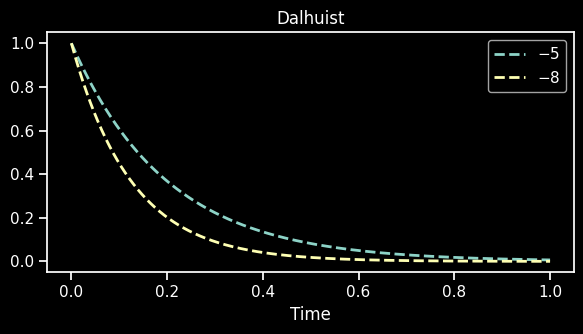

In [4]:
d5_to_plot = X1_raw[:plt_hor]
ax = sbplot(d5_to_plot[:, -1], d5_to_plot[:, 0], "--", x_label='Time', label=r'$-5$', title='Dalhuist')

d8_to_plot = X2_raw[:plt_hor]
ax = sbplot(d8_to_plot[:, -1], d8_to_plot[:, 0], "--", x_label='Time', label=r'$-8$', ax=ax)

In [5]:
class Encoder(eqx.Module):
    # layers: list

    def __init__(self, in_size=2, out_size=2, key=None):
        # keys = get_new_key(key, num=2)
        # self.layers = [eqx.nn.Linear(in_size, 10, key=keys[0]), jax.nn.tanh,
        #                 eqx.nn.Linear(10, out_size, key=keys[1]) ]
        return

    def __call__(self, x):
        # for layer in self.layers:
        #     x = layer(x)
        return x

class Processor(eqx.Module):
    layers: list
    # lamb: jnp.ndarray

    def __init__(self, in_out_size=2, key=None):
        keys = get_new_key(key, num=2)
        self.layers = [eqx.nn.Linear(in_out_size+1, 10, key=keys[0]), jax.nn.tanh,
                        eqx.nn.Linear(10, in_out_size, key=keys[1])]

        # self.lamb = jnp.array([-13.0])
        # self.lamb = jax.random.uniform(get_new_key(key), (1,))*20

    def __call__(self, x, t):
        y = jnp.concatenate([jnp.broadcast_to(t, (1,)), x], axis=0)
        for layer in self.layers:
            y = layer(y)
        return y
        # return self.lamb[0]*x


class Decoder(eqx.Module):
    layers: list
    # params_comp: jnp.ndarray    ## The other system's parameters

    def __init__(self, in_size=2, out_size=2, key=None):
        keys = get_new_key(key, num=2)
        self.layers = [eqx.nn.Linear(in_size, 10, key=keys[0]), jax.nn.tanh,
                        eqx.nn.Linear(10, out_size, key=keys[1]) ]

        # self.params_comp = jnp.array([1.0, -8])
        # self.params_comp = jax.random.uniform(get_new_key(key), (2,))*20

    def __call__(self, z, x0, t):
        z = jnp.concatenate([z, x0, jnp.broadcast_to(t, (1,))], axis=0)
        for layer in self.layers:
            z = layer(z)
        return z

        # init_, lamb_ = self.params_comp
        # return (z/init_)*jnp.exp(-lamb_*t)

keys = get_new_key(SEED, num=5)

d1 = X1.shape[-1] - 1
E1 = Encoder(in_size=d1, out_size=latent_size, key=keys[0])
D1 = Decoder(in_size=latent_size+d1+1, out_size=d1, key=keys[1])

d2 = X2.shape[-1] - 1
E2 = Encoder(in_size=d2, out_size=latent_size, key=keys[2])
D2 = Decoder(in_size=latent_size+d2+1, out_size=d2, key=keys[3])

P = Processor(in_out_size=latent_size*1, key=keys[4])

# D2 = eqx.tree_at(lambda x: x.params_comp, D2, jnp.array([1.0, -5]))

model = (E1, E2, P, D1, D2)
params, static = eqx.partition(model, eqx.is_array)

In [6]:
# E1, E2, P, D1, D2 = model
# print(P.lamb)
# print(D1.params_comp)
# print(D2.params_comp)

In [7]:
def l2_norm(X, X_hat):
    ## Norms of 2-dimensional and 4-dimensional vectors
    total_loss =  jnp.mean((X - X_hat)**2, axis=-1)
    return jnp.sum(total_loss) / (X.shape[0] * X.shape[1])

def loss_fn(params, static, batch):
    X1, X2 = batch
    model = eqx.combine(params, static)

    E1, E2, P, D1, D2 = model       ## TODO vmap the model directly

    E1_batched, E2_batched = jax.vmap(E1), jax.vmap(E2)
    latent1 = E1_batched(X1[:, 0, :-1])
    latent2 = E2_batched(X2[:, 0, :-1])

    # latent = jnp.concatenate([latent1, latent2], axis=-1)       ## TODO only latent1 used
    latent = latent1 * latent2
    t = X1[:, :, -1]
    # print("This is t:", t.shape, t)

    P_params, P_static = eqx.partition(P, eqx.is_array)
    integrator_batched = jax.vmap(integrator, in_axes=(None, None, 0, 0, None, None, None, None, None, None))

    ## Check these params !!
    latent_final = integrator_batched(P_params, P_static, latent, t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 50, "checkpointed")

    # latent_dot = P(latent, t)     ## TODO apparently, it is tradition to let the dot go to ZERO

    D1_, D2_ = jax.vmap(D1, in_axes=(0, None, 0)), jax.vmap(D2, in_axes=(0, None, 0))
    D1_batched, D2_batched = jax.vmap(D1_, in_axes=(0, 0, 0)), jax.vmap(D2_, in_axes=(0, 0, 0))

    X1_hat = D1_batched(latent_final, X1[:, 0, :-1], t)
    X2_hat = D2_batched(latent_final, X2[:, 0, :-1], t)

    return l2_norm(X1[..., :-1], X1_hat) + l2_norm(X2[..., :-1], X2_hat)

@partial(jax.jit, static_argnums=(1))
def train_step(params, static, batch, opt_state):
    print('\nCompiling function "train_step" ...\n')

    loss, grads = jax.value_and_grad(loss_fn)(params, static, batch)

    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [8]:
nb_examples = X1.shape[0]

sched = optax.exponential_decay(init_lr, nb_epochs*int(np.ceil(nb_examples//batch_size)), decay_rate)
opt = optax.adam(sched)
opt_state = opt.init(params)

start_time = time.time()

losses = []
for epoch in range(nb_epochs):

    nb_batches = 0
    loss_sum = 0.
    for i in range(0, nb_examples, batch_size):
        batch = (X1[i:i+batch_size], X2[i:i+batch_size])      ## TODO vmap to increase this batch size
    
        params, opt_state, loss = train_step(params, static, batch, opt_state)

        loss_sum += loss
        nb_batches += 1

    loss_epoch = loss_sum/nb_batches
    losses.append(loss_epoch)

    if epoch%print_every==0 or epoch<=3 or epoch==nb_epochs-1:
        print(f"Epoch: {epoch:-5d}      Loss: {loss_epoch:.8f}")


wall_time = time.time() - start_time
time_in_hmsecs = seconds_to_hours(wall_time)
print("\nTotal training time: %d hours %d mins %d secs" %time_in_hmsecs)

model = eqx.combine(params, static)


Compiling function "train_step" ...


Compiling function "train_step" ...

Epoch:     0      Loss: 0.48160902
Epoch:     1      Loss: 0.45401961
Epoch:     2      Loss: 0.42747021
Epoch:     3      Loss: 0.40200564
Epoch:   100      Loss: 0.00444669
Epoch:   200      Loss: 0.00291724
Epoch:   300      Loss: 0.00256112
Epoch:   400      Loss: 0.00220483
Epoch:   500      Loss: 0.00173313
Epoch:   600      Loss: 0.00120273
Epoch:   700      Loss: 0.00079002
Epoch:   800      Loss: 0.00053325
Epoch:   900      Loss: 0.00038290
Epoch:  1000      Loss: 0.00028542
Epoch:  1100      Loss: 0.00021334
Epoch:  1200      Loss: 0.00015860
Epoch:  1300      Loss: 0.00011885
Epoch:  1400      Loss: 0.00009181
Epoch:  1500      Loss: 0.00007440
Epoch:  1600      Loss: 0.00006330
Epoch:  1700      Loss: 0.00005571
Epoch:  1800      Loss: 0.00004984
Epoch:  1900      Loss: 0.00004470
Epoch:  2000      Loss: 0.00003986
Epoch:  2100      Loss: 0.00003543
Epoch:  2200      Loss: 0.00003171
Epoch:  2300  

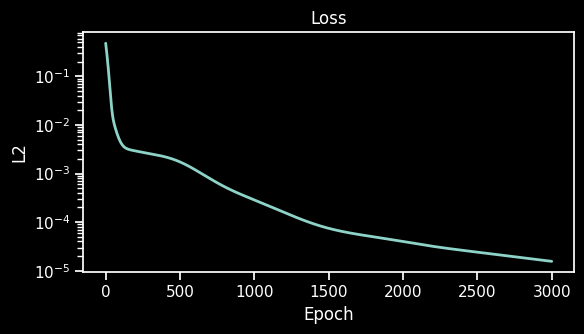

In [9]:
sbplot(losses, x_label='Epoch', y_label='L2', y_scale="log", title='Loss');

==== Reconstruction errors ====
  - D5 Dahlquist: 0.03716
  - D8 Dahlquist: 0.00318


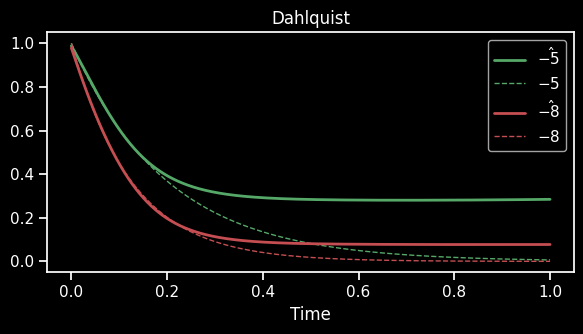

In [10]:
def test_model(model, X1, X2):
    E1, E2, P, D1, D2 = model

    latent1 = E1(X1[0, :-1])
    latent2 = E2(X2[0, :-1])

    # latent = jnp.concatenate([latent1, latent2], axis=-1)
    latent = latent1 * latent2
    t = X1[:, -1]

    P_params, P_static = eqx.partition(P, eqx.is_array)
    latent_final = integrator(P_params, P_static, latent, t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 2, "checkpointed")

    D1_, D2_ = jax.vmap(D1, in_axes=(0, None, 0)), jax.vmap(D2, in_axes=(0, None, 0))
    # X1_hat = D1_(latent_final[:, :latent_size])
    # X2_hat = D2_(latent_final[:, latent_size:])

    X1_hat = D1_(latent_final, X1[0, :-1], t)
    X2_hat = D2_(latent_final, X2[0, :-1], t)

    # print("Test value:", D2(latent_final[0], X2[0, :-1], t[0]), X2_hat[0])
    # print("Test value:", E2(X2[0, :-1]))

    return X1_hat, X2_hat

X1_hat, X2_hat = test_model(model, X1_raw, X2_raw)

plt_hor = plt_hor*1

times = X1_raw[:plt_hor, -1]

d5_to_plot_ = X1_hat[:plt_hor]
d5_to_plot = X1_raw[:plt_hor]
ax = sbplot(times, d5_to_plot_[:, 0], "g-", x_label='Time', label=r'$\hat{-5}$', title='Dahlquist')
ax = sbplot(times, d5_to_plot[:, 0], "g--", lw=1, x_label='Time', label=r'$-5$',ax=ax)
 
d8_to_plot_ = X2_hat[:plt_hor]
d8_to_plot = X2_raw[:plt_hor]
ax = sbplot(times, d8_to_plot_[:, 0], "r-", x_label='Time', label=r'$\hat{-8}$', ax=ax)
ax = sbplot(times, d8_to_plot[:, 0], "r--", lw=1, x_label='Time', label=r'$-8$', ax=ax)

RE1 = l2_norm(X1_raw[..., :-1], X1_hat)
RE2 = l2_norm(X2_raw[..., :-1], X2_hat)
print("==== Reconstruction errors ====")
print(f"  - D5 Dahlquist: {RE1:.5f}")
print(f"  - D8 Dahlquist: {RE2:.5f}")

In [11]:
eqx.tree_serialise_leaves("data/model_003.eqx", model)
# model = eqx.tree_deserialise_leaves("data/model001.eqx", model)

 # Reconstruction errors
 - Only latent1 used:
 - Only latent2 used:
 # Conclusion

 Could we have one encoder, multiple processors, one decoder? The processors would work as follows:

 $$  \frac{dY}{dt} = \alpha_1 F_{\theta_1} + \alpha_2 F_{\theta_2} + ...+ \alpha_K F_{\theta_K} $$

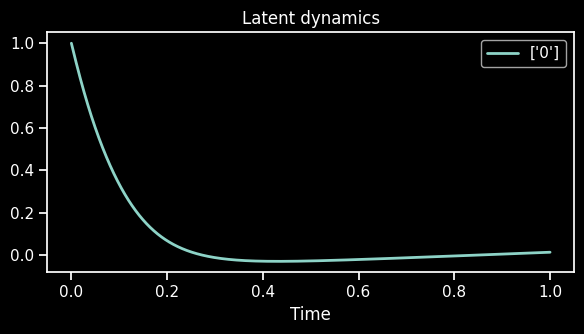

In [12]:
def test_processor(model, X_latent, t):
    _, _, P, _, _ = model

    P_params, P_static = eqx.partition(P, eqx.is_array)
    latent_final = integrator(P_params, P_static, X_latent, t, 1.4e-8, 1.4e-8, jnp.inf, jnp.inf, 2, "checkpointed")

    return latent_final

# X_latent = jnp.array([0.0, 0.1, 0.0, 0.1])
# X_latent = jax.random.uniform(get_new_key(SEED), (1,))
X_latent = 1*jnp.ones((1,))
test_t = jnp.linspace(0, 1, 10001)

X_latent_final = test_processor(model, X_latent, test_t)
labels = [str(i) for i in range(X_latent_final.shape[-1])]

sbplot(test_t, X_latent_final[:, :], x_label='Time', label=labels, title='Latent dynamics');

In [13]:
# E1, E2, P, D1, D2 = model
# print(P.lamb)
# print(D1.params_comp)
# print(D2.params_comp)